In [1]:
## magics

%load_ext version_information 
%version_information numpy,xarray,netCDF4


Software versions
Python 2.7.15 64bit [GCC 7.2.0]
IPython 4.2.0
OS Linux 3.16.0 6 amd64 x86_64 with debian 8.11
numpy 1.11.2
xarray 0.10.4
netCDF4 1.4.0
Thu Sep 27 09:28:42 2018 CEST

In [2]:
## path for mdules

import sys
sys.path.insert(0,"/home/albert/lib/python")

## imports

import numpy as np
import xarray as xr
import GriddedData
import time

#- Other modules
import numpy.ma as ma
import WavenumberSpectrum as ws

### palette
import matplotlib.cm as mplcm

seq_cmap = mplcm.Blues
div_cmap = mplcm.seismic

### quick plot
import matplotlib.pyplot as plt

## local/specific imports
import oocgcm
import oocgcm.filtering
import oocgcm.filtering.linearfilters as tf
%matplotlib inline


In [5]:
# compute the spectra over 10°x10° box for one example file

test="/mnt/albert/equipes/meom/workdir/albert/NATL60/NATL60-CJM165-S/surf/NATL60-CJM165_y2012m10d01.1d_sosaline.nc"
tf_test="/mnt/albert/equipes/meom/workdir/albert/NATL60/NATL60-CJM165-S/filt/filtNATL60-CJM165_y2012m10d01.1d_sosaline_filt-n80-f0.1.nc"

gridfile="/mnt/albert/equipes/meom/workdir/albert/NATL60/NATL60-I/NATL60_v4.1_cdf_byte_mask_z1-52.nc"

ds = xr.open_dataset(test)
hpds = xr.open_dataset(tf_test)
grid=xr.open_dataset(gridfile)

navlon = np.array(grid["nav_lon"]).squeeze()
navlat = np.array(grid["nav_lat"]).squeeze()

curl = ds['sosaline']
hpcurl = hpds['sosaline_filt']


zfull = curl[0,600:1200,1800:2400].values # si pas .values plot ok mais ne peut pas calculer le spectre
zfull[np.where(np.isnan(zfull))]=0. # 0. are missing values so they are converted to nan

zhp = hpcurl[0,600:1200,1800:2400].values
zhp[np.where(np.isnan(zhp))]=0. # 0. are missing values so they are converted to nan

zlp = zfull - zhp

zlon = navlon[600:1200,1800:2400]
zlat = navlat[600:1200,1800:2400]

#- compute the wavenumber spectrum
interp = 'basemap'

def compute_spectrum(var):
    data = var.squeeze()
    x_reg,y_reg,data_reg = ws.interpolate(data,zlon,zlat,interp=interp)
    pspec,kstep = ws.get_spectrum_1d(data_reg,x_reg,y_reg)
    return pspec, kstep

%time spectre_full = compute_spectrum(zfull)
%time spectre_hp   = compute_spectrum(zhp)
%time spectre_lp   = compute_spectrum(zlp)

#- plot the mean spectrum 
rad2cyc = 1.E3 / np.pi / 2. 

def nice_spectrum(spectre_full,spectre_hp,spectre_lp):
    fig, axarr = plt.subplots(1,1)
    fig.set_figheight(8)
    fig.set_figwidth(15)
    #
    pspec,kstep = spectre_full
    pspec_lp,kstep_lp = spectre_lp
    pspec_hp,kstep_hp = spectre_hp
    skstep = kstep * rad2cyc
    y_min = 10 ** np.floor(np.log10(pspec.min())-1)
    y_max = 10 ** np.ceil( np.log10(pspec.max())+1)
    axarr.plot(skstep[1:], pspec[1:],'k-', lw=3, label='Full surface salinity')
    axarr.plot(skstep[1:], pspec_lp[1:],'r-', lw=3, label='Low passed salinity f=0.1 n=80')
    axarr.plot(skstep[1:], pspec_hp[1:],'b-', lw=3, label='Full - Low passed  f=0.1 n=80')
    axarr.set_xscale('log')
    axarr.set_yscale('log')
    axarr.set_xbound(1e-5*rad2cyc, 1e-2*rad2cyc)
    axarr.set_ybound(y_min, y_max)
    axarr.set_title('',fontsize=20)
    axarr.grid(True,which='both',ls='-')
    axarr.axis('tight')
    axarr.legend(loc="lower left", fontsize=25)
    axarr.tick_params(labelsize=25)





CPU times: user 1.44 s, sys: 0 ns, total: 1.44 s
Wall time: 1.45 s
CPU times: user 1.44 s, sys: 0 ns, total: 1.44 s
Wall time: 1.43 s
CPU times: user 1.43 s, sys: 12 ms, total: 1.44 s
Wall time: 1.44 s


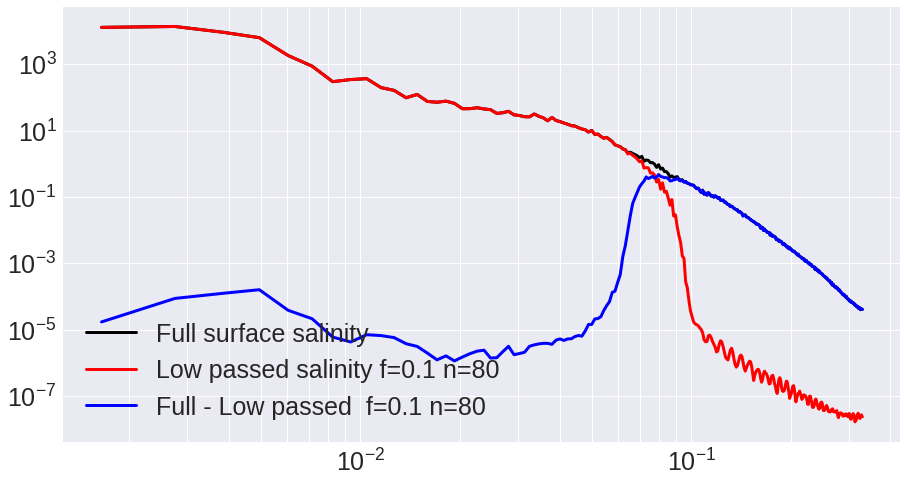

In [6]:
nice_spectrum(spectre_full,spectre_hp,spectre_lp)